# Origin of Olive Oils

*splines*, *functional pca*, *classification*, *high-dimensional*

\textbf{Problem}

Olive oil is cultivated extensively across the Mediterranean basin. It is known that the composition of olive oils varies with geographic origin due to a number of different factors: regional differences in climate, soil, and agricultural practice. Verifying the declared origin, or determining the origin of an unidentified olive oil, is, therefore, a challenging problem. In this question our goal is to distinguish extra virgin olive oils from different producing countries. `oil.csv` dataset contains 60 authenticated samples of extra virgin olive oils, originating from four European producing countries: Greece, Italy, Portugal, and Spain.

The goal is to classify the origin country based on sample data.

\textbf{Method}

The data given is the absorbance spectra of 60 oil samples. Each sample is a signal of 571 data points. This is a high-dimensional problem where the number of dimensions is much higher than that of number of samples. We will compare classification using two dimension reduction approaches: B-splines and Functional PCA. We will use multiclass SVM as the classifier. 

We use the first 30 data samples for training; and the rest to evaluate the accuracy of models. 

\textbf{Results}

The test classification accuracy using B-spline for dimension reduction is 0.87. On the other hand, doing dimension reduction using FPCA (5 principal components) can achieve test accuracy of 0.9.

In [63]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings
from scipy.interpolate import BSpline, splev, splrep, CubicSpline
from sklearn.model_selection import KFold, LeaveOneOut
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rcParams['figure.figsize'] = (4, 3)

In [76]:
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from scipy.ndimage import gaussian_filter
from matplotlib import cm

In [77]:
data = pd.read_csv("data/oil.csv", header=None)
data.shape

(60, 571)

In [78]:
# classes are a little imbalanced 
data.iloc[:, -1].value_counts()

4    25
2    17
1    10
3     8
Name: 570, dtype: int64

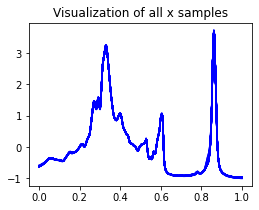

In [79]:
# visualize: they all look very similar
data = np.asarray(data)
m = data.shape[1] - 1 # 570 data points per curve
n = data.shape[0]     # 60 curves 
plt.plot(np.linspace(0, 1, m), data[:, :-1].T, 'b')
plt.title('Visualization of all x samples')
plt.show()

In [80]:
# split into train and test data sets
x_train, x_test, y_train, y_test = data[:30, :-1], data[30:, :-1], data[:30, -1], data[30:, -1]

In [81]:
# standardize data based on training data
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

## B-splines

B-splines reduce the dimension form 570 to 74 (K+M). 

In [82]:
# compute spline coefficients of each x vector as dimension reduction
x = np.linspace(0, 1, m)
n_knots = 70
knots = np.linspace(0, 1, n_knots + 2)
Bcoef_train = bSpline(knots).fit(x, x_train.T).Bcoefs.T 
Bcoef_test = bSpline(knots).fit(x, x_test.T).Bcoefs.T 
Bcoef_train.shape

(30, 74)

In [83]:
# classification 
clf = svm.SVC(decision_function_shape='ovo', kernel='rbf', C=1).fit(Bcoef_train, y_train)
yhat = clf.predict(Bcoef_test)
print("Accuracy:", sum(yhat == y_test) / 30)
conf = confusion_matrix(yhat, y_test)
print('Confusion Matrix:')
print(conf)

Accuracy: 0.8666666666666667
Confusion Matrix:
[[ 5  0  0  0]
 [ 0  9  1  1]
 [ 0  0  1  0]
 [ 0  0  2 11]]


## Functional PCA

We use FPCA to reduce dimensions to 2,5,8,10 PCs.

In [84]:
def fitFPCA(X, n_pc, plot=False): 
    
    # Get basis function matrix for a single x vector 
    x = np.linspace(0, 1, m)   # 570 x 1
    n_knots = 70 - 2           # total of 70 knots including end points
    knots = np.linspace(0, 1, n_knots + 2) 
    B = bSpline(knots).BSplineBasis(x)[:,:-2] # 570 x 72 basis functions

    # fit a b-spline using all curves stacked together to get "global coefficients"
    B_stacked = np.tile(B.T, n).T
    X_stacked = X.ravel()
    beta = np.linalg.lstsq(B_stacked, X_stacked)[0]

    # estimate the mean function
    mu_hat = B.dot(beta)
    if plot: 
        plt.plot(x, X.mean(0), 'k+-', label='Mean of data')
        plt.plot(x, mu_hat, 'b', label='Mean function via Spline')
        plt.legend()
        plt.title("Mean Estimate")
        plt.show()

    # estimate covariance matrix 
    diffs = X - mu_hat
    Cov = np.cov(diffs.T)
    
    # additional Cov smoothing:
    Cov = gaussian_filter(Cov, sigma=7)
    if plot: 
        grids = np.meshgrid(x, x)
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.plot_surface(grids[0], grids[1], Cov, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        plt.title('Smoothed Covariances')
        plt.show()
    
    # compute eigenfunctions 
    l, psi = np.linalg.eigh(Cov)
    PCs = psi[:, -n_pc:]
    FPC_scores = diffs.dot(PCs)

    return FPC_scores

In [85]:
X = np.concatenate((x_train, x_test))

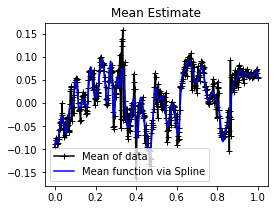

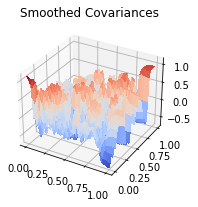

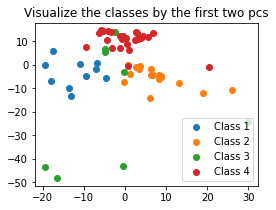

In [86]:
# test the function using two PCs
FPC_scores = fitFPCA(X, n_pc=2, plot=True) 

# visualization 
for i in range(1,5):
    idx = np.where(data[:, -1] == i)
    plt.scatter(FPC_scores[idx,0], FPC_scores[idx,1], label='Class ' + str(i))
plt.legend()
plt.title("Visualize the classes by the first two pcs")
plt.show()

We use multiclass SVM for classification. Since sample size is imbalanced, we assign class weights inversely proportional to the number of samples.

In [87]:
# classification using different number of PCs
for n_pc in [2,5,8,10]:
    FPC_scores = fitFPCA(X, n_pc=n_pc, plot=False) 
    #clf = RandomForestClassifier()
    clf = svm.SVC(decision_function_shape='ovo', class_weight='balanced', kernel='linear', C=1) 
    clf.fit(FPC_scores[:30], y_train)
    yhat = clf.predict(FPC_scores[30:])
    print("Number of PCs:", n_pc, " Accuracy:", round(sum(yhat == y_test) / 30, 2))
    conf = confusion_matrix(yhat, y_test)
    print(conf)

Number of PCs: 2  Accuracy: 0.8
[[ 4  0  1  0]
 [ 0  9  2  1]
 [ 1  0  0  0]
 [ 0  0  1 11]]
Number of PCs: 5  Accuracy: 0.9
[[ 5  0  0  0]
 [ 0  9  1  1]
 [ 0  0  2  0]
 [ 0  0  1 11]]
Number of PCs: 8  Accuracy: 0.87
[[ 5  0  0  0]
 [ 0  9  1  1]
 [ 0  0  1  0]
 [ 0  0  2 11]]
Number of PCs: 10  Accuracy: 0.87
[[ 5  0  0  0]
 [ 0  9  1  1]
 [ 0  0  1  0]
 [ 0  0  2 11]]
